In [33]:
import scanpy as sc 
import numpy as np
import pandas as pd
import scanpy.external as sce
from collections import Counter

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    sc.tl.rank_genes_groups(adata, groupby="leiden")
    return(adata)

In [3]:
%%time
adata = sc.read_h5ad("01_Sim_adata.h5ad")
adata

CPU times: user 276 ms, sys: 1.85 s, total: 2.13 s
Wall time: 2.13 s


AnnData object with n_obs × n_vars = 54140 × 33939
    obs: 'donor_id', 'age', 'sex', 'age_status', 'region', 'cell_or_nuclei', 'technology', 'study', 'disease'
    layers: 'counts'

### Filter to fetal

In [4]:
adata = adata[adata.obs.age_status == "Fetal", :].copy()
adata

AnnData object with n_obs × n_vars = 27760 × 33939
    obs: 'donor_id', 'age', 'sex', 'age_status', 'region', 'cell_or_nuclei', 'technology', 'study', 'disease'
    layers: 'counts'

### Perform preprocessing

In [5]:
# store the raw counts
adata.layers["counts"] = adata.X

In [6]:
# perform initial filtering
sc.pp.filter_genes(adata, min_cells = 5)
sc.pp.filter_cells(adata, min_genes = 200)

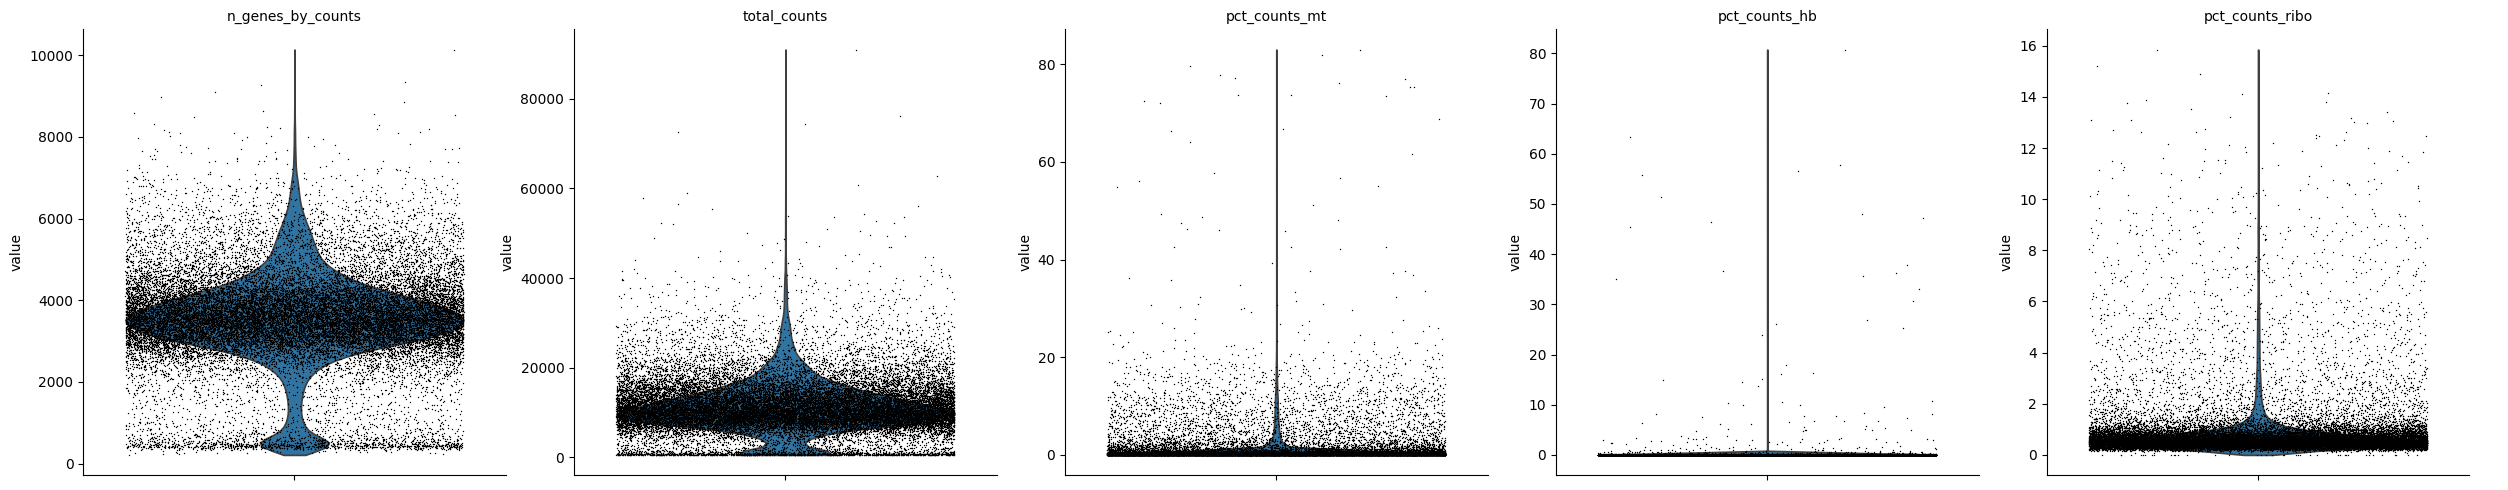

Filtered out 395 cells


In [7]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"],
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 15.0
ribo_threshold = 15.0
hb_threshold = 5.0

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [8]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
print("Performing scrublet analysis...")
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Performing scrublet analysis...
Filtered out 524 likely doublets
CPU times: user 10min 57s, sys: 9min, total: 19min 58s
Wall time: 3min 44s


Running the preprocessing and leiden clustering...


2024-11-23 19:32:40,916 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 19:32:43,817 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 19:32:43,900 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 19:32:49,522 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 19:32:54,924 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 19:33:00,319 - harmonypy - INFO - Iteration 4 of 10
2024-11-23 19:33:05,760 - harmonypy - INFO - Iteration 5 of 10
2024-11-23 19:33:11,560 - harmonypy - INFO - Iteration 6 of 10
2024-11-23 19:33:15,026 - harmonypy - INFO - Converged after 6 iterations


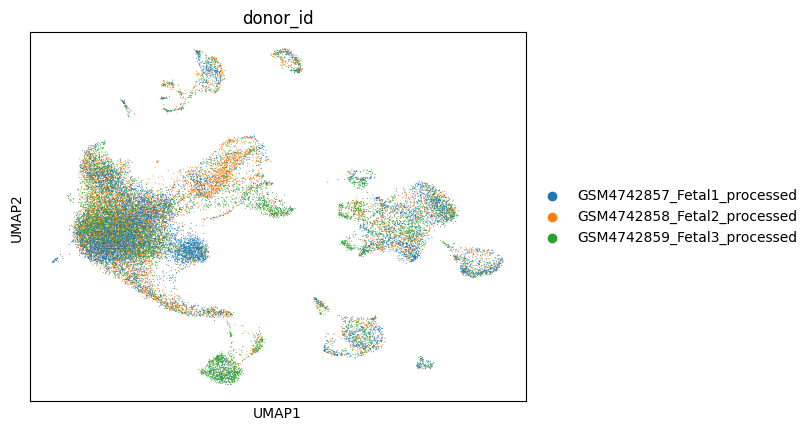

CPU times: user 11min 17s, sys: 35min 29s, total: 46min 46s
Wall time: 1min 13s


In [9]:
%%time
print("Running the preprocessing and leiden clustering...", flush=True)
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata,
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

### Identify differentially expressed genes

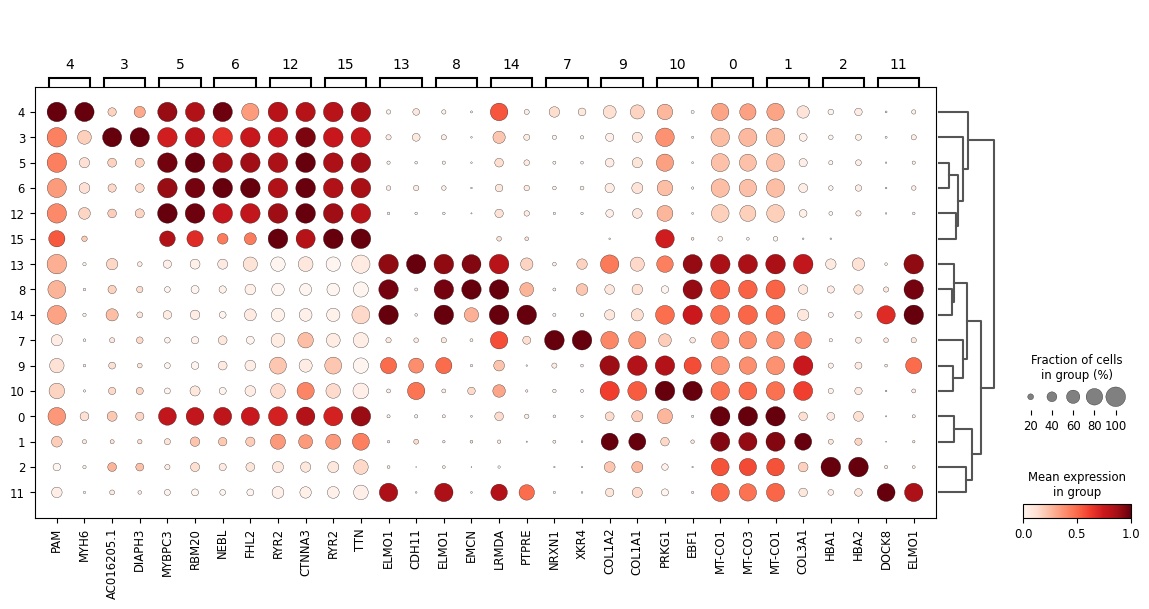

CPU times: user 1.2 s, sys: 178 ms, total: 1.38 s
Wall time: 1.2 s


In [10]:
%%time
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=2)

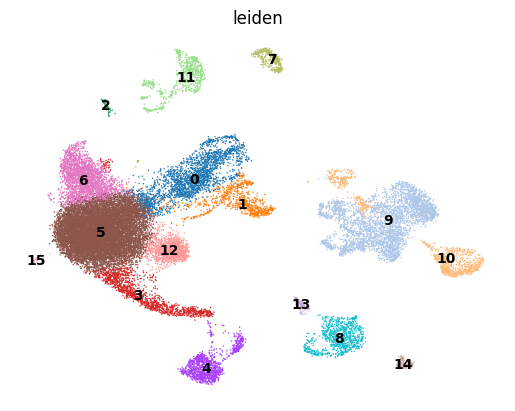

In [13]:
sc.pl.umap(adata,color=["leiden"], legend_loc="on data",frameon=False)

In [41]:
sc.get.rank_genes_groups_df(adata, group="4").head(20)

,names,scores,logfoldchanges,pvals,pvals_adj
0,PAM,116.114647,3.917526,0.0,0.0
1,MYH6,102.910355,5.588877,0.0,0.0
2,EPHA4,92.667046,6.410207,0.0,0.0
3,PLCB1,81.826157,4.515463,0.0,0.0
4,TBX5,79.302483,3.465849,0.0,0.0
5,SLIT3,72.986923,4.494928,0.0,0.0
6,KCNJ3,65.983147,7.674792,0.0,0.0
7,TTN,63.423458,1.419163,0.0,0.0
8,PRKAG2,62.287685,2.903829,0.0,0.0
9,L3MBTL4,62.216507,2.831971,0.0,0.0


### Perform cluster annotation

In [42]:
adata.obs["cell_type"] = adata.obs["leiden"].map(
    {
        "0": "High-mito",
        "1": "High-mito",
        "2": "RBC",
        "3": "High-mito",
        "4": "Unclear",
        "5": "Cardiomyocyte",
        "6": "Cardiomyocyte",
        "7": "Neuronal",
        "8": "Endothelial",
        "9": "Fibroblast",
        "10": "Pericyte",
        "11": "Myeloid",
        "12": "Cardiomyocyte",
        "13": "Endocardial",
        "14": "Unclear",
        "15": "Cardiomyocyte"
    }
)

In [43]:
Counter(adata.obs["cell_type"])

Counter({'Cardiomyocyte': 14713,
         'Fibroblast': 3408,
         'Unclear': 1255,
         'Pericyte': 1009,
         'Endothelial': 891,
         'Myeloid': 715,
         'Neuronal': 318,
         'Endocardial': 127})

In [44]:
# since we annotated it, copy over the cell_type to consistent_cell_type
adata.obs["consistent_cell_type"] = adata.obs["cell_type"]

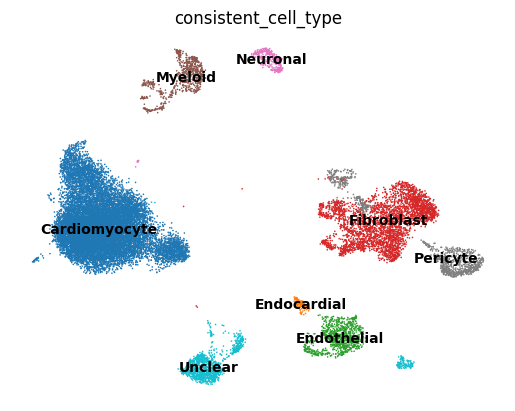

In [45]:
sc.pl.umap(adata,color=["consistent_cell_type"], legend_loc="on data",frameon=False)

### Two clusters are cell types that are unclear

In [46]:
# restore the raw counts
adata.X = adata.layers["counts"]

In [47]:
%%time
# remove the high-mito clusters and RBC
adata = adata[~adata.obs.cell_type.isin(["High-mito", "RBC"]), :].copy()
adata

CPU times: user 581 ms, sys: 654 ms, total: 1.24 s
Wall time: 1.23 s


AnnData object with n_obs × n_vars = 22436 × 27707
    obs: 'donor_id', 'age', 'sex', 'age_status', 'region', 'cell_or_nuclei', 'technology', 'study', 'disease', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'leiden', 'cell_type', 'consistent_cell_type'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'

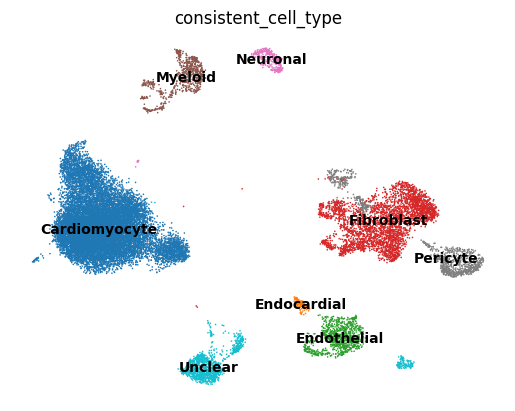

In [49]:
sc.pl.umap(adata,color=["consistent_cell_type"], legend_loc="on data",frameon=False)

In [50]:
adata.write("02_Sim_fetal.h5ad")